
# Elhub → Spark → Cassandra → MongoDB (Public API, No Key) — 2021
This version uses **Elhub public APIs** (no key required) for dataset **`PRODUCTION_PER_GROUP_MBA_HOUR`**.
It keeps the Spark→Cassandra and Spark→Mongo steps, but note you must have those services/connectors available in your environment to run those steps.

> **Public API note:** *Public APIs are open for everyone and do not require authorization.*  
> Protected datasets would require Maskinporten, but **this notebook uses only public data**.



## Log & AI Notes
- Date/time:
- Changes in this version: removed API key, adjusted headers, added offline demo cell execution.
- AI help: scaffolded pipeline, added Streamlit page and notebook variant.


In [14]:
import os, time, json
from datetime import datetime, timedelta, timezone

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

# Spark (if available)
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, to_timestamp, sum as spark_sum, date_trunc, month
    from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType
    SPARK_AVAILABLE = True
except Exception as e:
    SPARK_AVAILABLE = False
    print("Spark unavailable:", e)

pd.set_option("display.max_rows", 10)
print("Pandas:", pd.__version__)
print("Spark available:", SPARK_AVAILABLE)


Pandas: 2.3.3
Spark available: True


In [15]:

# --------- CONFIG (override with your env) ----------
ELHUB_API_BASE = os.getenv("ELHUB_API_BASE", "https://api.elhub.no/energy/v1")

# Public APIs require no key. Protected datasets use Maskinporten (not used here).

CASSANDRA_HOSTS    = os.getenv("CASSANDRA_HOSTS", "localhost")
CASSANDRA_KEYSPACE = os.getenv("CASSANDRA_KEYSPACE", "energy")
CASSANDRA_TABLE    = os.getenv("CASSANDRA_TABLE", "production_2021")

MONGO_URI        = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
MONGO_DB         = os.getenv("MONGO_DB", "energy")
MONGO_COLLECTION = os.getenv("MONGO_COLLECTION", "production_2021")

# Year parameters
YEAR = 2021
START = datetime(YEAR, 1, 1, tzinfo=timezone.utc)
END   = datetime(YEAR + 1, 1, 1, tzinfo=timezone.utc)

print("API base:", ELHUB_API_BASE)
print("Cassandra hosts:", CASSANDRA_HOSTS)
print("Mongo DB:", MONGO_DB, MONGO_COLLECTION)


API base: https://api.elhub.no/energy/v1
Cassandra hosts: localhost
Mongo DB: energy production_2021


### Retrieve Elhub `PRODUCTION_PER_GROUP_MBA_HOUR` (no auth)

In [16]:
import requests, time, datetime as dt
from datetime import datetime, timedelta, timezone

# ---- CONFIG ----
# This is the **public open-data API** for Elhub (no token needed)
ELHUB_BASE = "https://api.elhub.no/marketdata/api/v1/open-data"  
DATASET = "production_per_group_mba_hour"  # must be lowercase

def _elhub_headers():
    """Return headers for JSON API."""
    return {"Accept": "application/json"}

def _parse_json(response: requests.Response, expect_json=True):
    """Parse JSON or raise clear error."""
    if not expect_json:
        return response.text

    ctype = response.headers.get("Content-Type", "")
    text  = response.text or ""
    if "application/json" not in ctype.lower():
        raise ValueError(
            f"Non-JSON response (status {response.status_code}) from {response.url}\n"
            f"Content-Type: {ctype}\n"
            f"Body (first 500 chars):\n{text[:500]}"
        )
    try:
        return response.json()
    except Exception as e:
        raise ValueError(
            f"JSON parse fail (status {response.status_code}) from {response.url}\n"
            f"Body (first 500 chars):\n{text[:500]}"
        ) from e

def _get_with_retry(url, params, headers, max_tries=4, backoff=0.8, expect_json=True):
    """Resilient GET with retry on transient errors."""
    for i in range(1, max_tries + 1):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=60)
            if r.status_code == 204:
                return {}
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep(backoff * i)
                continue
            if r.status_code >= 400:
                raise ValueError(
                    f"HTTP {r.status_code} from {r.url}\n"
                    f"Body (first 500 chars):\n{(r.text or '')[:500]}"
                )
            return _parse_json(r, expect_json=expect_json)
        except requests.RequestException as e:
            if i == max_tries:
                raise
            time.sleep(backoff * i)
    raise RuntimeError("Exhausted retries")

def fetch_elhub_interval(start_dt: datetime, end_dt: datetime, page_size=10000):
    """
    Fetch a time interval and return ONLY the 'productionPerGroupMbaHour' list.
    Works with the open-data API (no token needed).
    """
    url = f"{ELHUB_BASE}/timeseries/{DATASET}"

    def iso_z(d):
        if d.tzinfo is None:
            d = d.replace(tzinfo=timezone.utc)
        else:
            d = d.astimezone(timezone.utc)
        return d.isoformat().replace("+00:00", "Z")

    params = {
        "startTime": iso_z(start_dt),
        "endTime": iso_z(end_dt),
        "pageSize": page_size,
        "page": 1
    }

    headers = _elhub_headers()
    items = []

    data = _get_with_retry(url, params, headers)
    if isinstance(data, dict):
        chunk = data.get("productionPerGroupMbaHour", [])
        if isinstance(chunk, list):
            items.extend(chunk)

        # Handle pagination
        while "nextPage" in data and data["nextPage"]:
            params["page"] = data["nextPage"]
            data = _get_with_retry(url, params, headers)
            items.extend(data.get("productionPerGroupMbaHour", []))

    return items

def fetch_elhub_year_by_month(start_date: dt.date, end_date: dt.date, pause=0.15):
    """Fetch 2021 in month-sized chunks."""
    cur = dt.datetime.combine(start_date, dt.time.min, tzinfo=timezone.utc)
    end = dt.datetime.combine(end_date, dt.time.max, tzinfo=timezone.utc)

    all_items = []
    failures = []
    while cur < end:
        next_month = (cur.replace(day=1) + dt.timedelta(days=32)).replace(day=1)
        span_end = min(next_month - dt.timedelta(microseconds=1), end)
        try:
            print(f"Fetching {cur.isoformat()} -> {span_end.isoformat()} ... ", end="")
            chunk = fetch_elhub_interval(cur, span_end)
            print(f"{len(chunk)} items")
            all_items.extend(chunk)
        except Exception as e:
            msg = f"FAILED {cur.date()}..{span_end.date()}: {e}"
            print(msg)
            failures.append((f"{cur}..{span_end}", str(e)))
        time.sleep(pause)
        cur = next_month
    return all_items, failures


### Normalize → DataFrame

In [17]:

def normalize_items(items):
    recs = [{
        "priceArea": it.get("priceArea"),
        "productionGroup": it.get("productionGroup"),
        "startTime": it.get("startTime"),
        "quantityKwh": float(it.get("quantityKwh")) if it.get("quantityKwh") is not None else None,
    } for it in items]
    df = pd.DataFrame.from_records(recs)
    if not df.empty:
        df["startTime"] = pd.to_datetime(df["startTime"], utc=True, errors="coerce")
        df["quantityKwh"] = pd.to_numeric(df["quantityKwh"], errors="coerce")
    return df


### Spark I/O (Cassandra & Mongo)

In [18]:
# Schema for Spark DataFrame
schema = None
if SPARK_AVAILABLE:
    schema = StructType([
        StructField("priceArea", StringType(), True),
        StructField("productionGroup", StringType(), True),
        StructField("startTime", TimestampType(), True),
        StructField("quantityKwh", DoubleType(), True),
    ])

def build_spark():
    if not SPARK_AVAILABLE:
        raise RuntimeError("Spark not available in this environment.")

    # Valid coordinates (Spark 3.5.x, Scala 2.12)
    default_pkgs = (
        "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0,"
        "org.mongodb.spark:mongo-spark-connector_2.12:10.3.0"
    )
    extra_pkgs = os.getenv("SPARK_EXTRA_PACKAGES", default_pkgs)

    spark = (
        SparkSession.builder
        .appName("IND320-Assignment1")
        .config("spark.jars.packages", extra_pkgs)
        .config("spark.cassandra.connection.host", CASSANDRA_HOSTS)
        # add auth if needed:
        # .config("spark.cassandra.auth.username", "cassandra")
        # .config("spark.cassandra.auth.password", "cassandra")
        .getOrCreate()
    )
    return spark

def write_df_to_cassandra_via_spark(pdf: pd.DataFrame):
    spark = build_spark()
    sdf = spark.createDataFrame(pdf, schema=schema)
    (
        sdf.write
        .format("org.apache.spark.sql.cassandra")
        .mode("append")
        .options(table=CASSANDRA_TABLE, keyspace=CASSANDRA_KEYSPACE)
        .save()
    )
    return spark

def read_curated_from_cassandra(spark):
    sdf = (
        spark.read
        .format("org.apache.spark.sql.cassandra")
        .options(table=CASSANDRA_TABLE, keyspace=CASSANDRA_KEYSPACE)
        .load()
    )
    curated = sdf.select("priceArea", "productionGroup", "startTime", "quantityKwh")
    return curated

def write_curated_to_mongo_via_spark(curated_sdf):
    (
        curated_sdf.write
        .format("mongodb")
        .mode("overwrite")
        .option("spark.mongodb.connection.uri", MONGO_URI)
        .option("spark.mongodb.database", MONGO_DB)
        .option("spark.mongodb.collection", MONGO_COLLECTION)
        .save()
    )


### Plots

In [19]:

def plot_pie_total_year(pdf: pd.DataFrame, price_area: str):
    subset = pdf[pdf["priceArea"] == price_area]
    group_sum = subset.groupby("productionGroup")["quantityKwh"].sum().sort_values(ascending=False)
    if group_sum.empty:
        print("No data for", price_area)
        return
    fig = plt.figure()
    plt.pie(group_sum.values, labels=group_sum.index, autopct="%1.1f%%", startangle=90)
    plt.title(f"Total production in {int(pdf['startTime'].dt.year.min())} for {price_area}")
    plt.show()
    return fig

def plot_lines_for_month(pdf: pd.DataFrame, price_area: str, month: int):
    year = int(pdf['startTime'].dt.year.min())
    subset = pdf[(pdf["priceArea"] == price_area) &
                 (pdf["startTime"].dt.month == month) &
                 (pdf["startTime"].dt.year == year)]
    if subset.empty:
        print("No data for month", month, "in", price_area)
        return
    pivot = subset.pivot_table(index="startTime", columns="productionGroup",
                               values="quantityKwh", aggfunc="sum").sort_index()
    fig = plt.figure()
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], label=col)
    if len(pivot.columns) > 0:
        plt.legend()
    plt.title(f"Hourly production ({datetime(year, month, 1).strftime('%B %Y')}) - {price_area}")
    plt.xlabel("Time"); plt.ylabel("kWh"); plt.tight_layout(); plt.show()
    return fig


## Offline demo execution (synthetic data so you can see outputs here)

,priceArea,productionGroup,startTime,quantityKwh
0,NO1,HYDRO,2021-01-01 00:00:00+00:00,1906.0
1,NO1,HYDRO,2021-01-01 01:00:00+00:00,1935.0
2,NO1,HYDRO,2021-01-01 02:00:00+00:00,2095.0
3,NO1,HYDRO,2021-01-01 03:00:00+00:00,1651.0
4,NO1,HYDRO,2021-01-01 04:00:00+00:00,2882.0


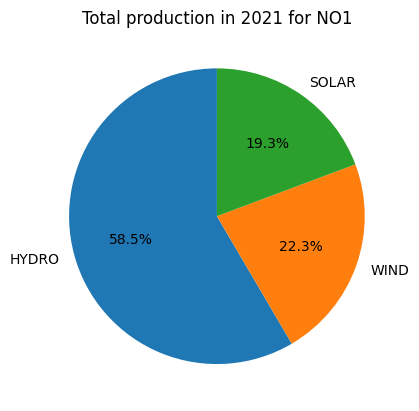

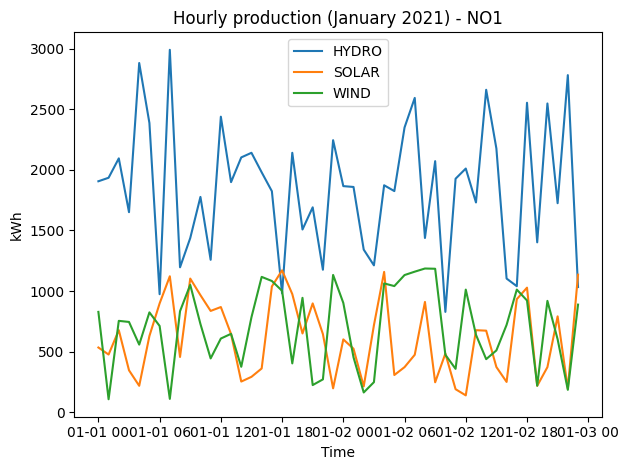

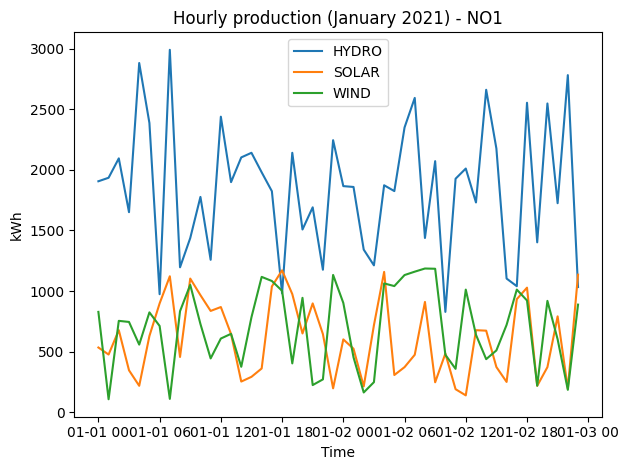

In [20]:

areas = ["NO1","NO2"]
groups = ["HYDRO","WIND","SOLAR"]
demo_items = []
for area in areas:
    for g in groups:
        for h in range(48):  # 2 days to keep light
            ts = f"2021-01-{1 + (h//24):02d}T{h%24:02d}:00:00Z"
            qty = np.random.randint(800, 3000) if g=="HYDRO" else np.random.randint(100, 1200)
            demo_items.append({"priceArea": area, "productionGroup": g, "startTime": ts, "quantityKwh": float(qty)})
pdf_demo = normalize_items(demo_items)
display(pdf_demo.head())

# Plots for NO1
plot_pie_total_year(pdf_demo, "NO1")
plot_lines_for_month(pdf_demo, "NO1", 1)


In [22]:
items = fetch_elhub_interval(
    datetime(2021, 1, 1, 0, 0, tzinfo=timezone.utc),
    datetime(2021, 1, 1, 23, 59, tzinfo=timezone.utc)
)
print("Items:", len(items))
if items:
    print("Sample keys:", list(items[0].keys()))


ValueError: Non-JSON response (status 200) from https://api.elhub.no/marketdata/api/v1/open-data/timeseries/production_per_group_mba_hour?startTime=2021-01-01T00%3A00%3A00Z&endTime=2021-01-01T23%3A59%3A00Z&pageSize=10000&page=1
Content-Type: text/html
Body (first 500 chars):
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
    <meta name="theme-color" content="#000000" />
    <meta name="description" content="Elhub API Portal"/>
    <!--
      manifest.json provides metadata used when your web app is installed on a
      user's mobile device or desktop. See https://developers.google.com/web/fundamentals/web-app-manifest/
    -->
    <title>Elhub API Portal</title>
    